### Biodiversity Project 

#### What factors impact conservation status?

can category and observation predict conservation status?

In [545]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Importing Data 

In [546]:
obs = pd.read_csv('observations.csv')
spec = pd.read_csv('species_info.csv')

In [547]:
obs.head()

,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


In [548]:
spec.head()

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


In [549]:
df = pd.merge(obs, spec, how='left', on = 'scientific_name')

### EDA - Distribution of numerical features by Categorical Variable

Text(0.5, 1.0, 'Distribution of Observation by Park')

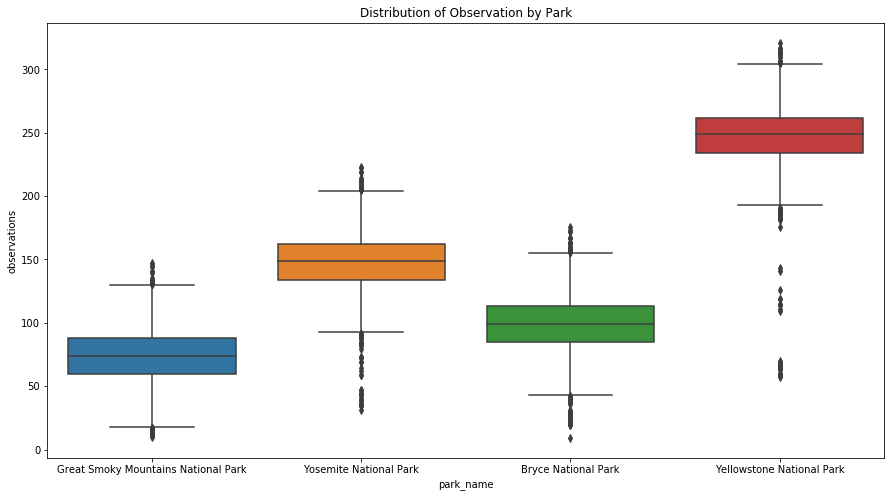

In [550]:
fig = plt.figure(figsize = (15,8))
sns.boxplot(data = df, x='park_name', y='observations').set_title('Distribution of Observation by Park')

Yellowstone National Park has consideravly more observation than other parks. 

Text(0.5, 1.0, 'Distribution of Observation by Category ')

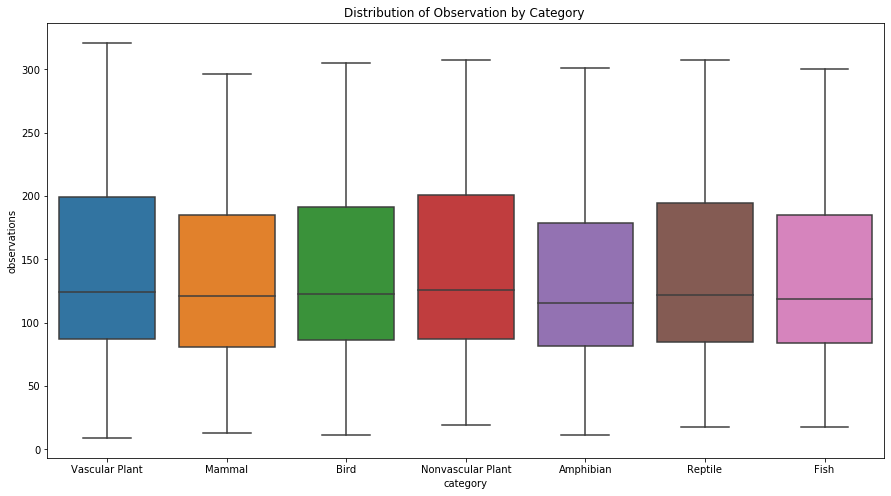

In [551]:
fig = plt.figure(figsize = (15,8))
sns.boxplot(data = df, x='category', y='observations').set_title('Distribution of Observation by Category ')

Median of observation does not change for different categories, IQR is very constant among all categories. 

Text(0.5, 1.0, 'Observations Distribution')

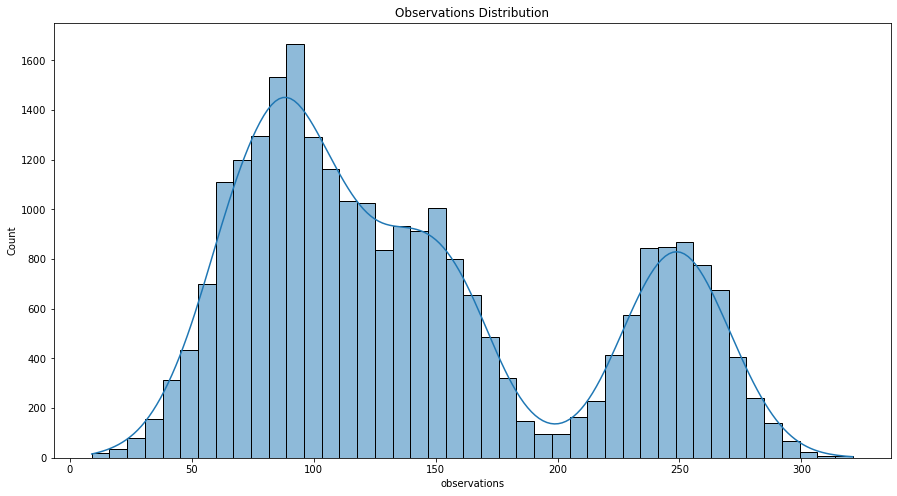

In [552]:
fig = plt.figure(figsize = (15,8))
sns.histplot(data = df, x='observations', kde=True).set_title('Observations Distribution')

Observation distribution is bimodal 

In [553]:
true = df.conservation_status.value_counts(normalize=True).reset_index()
true.conservation_status = true.conservation_status *100
true.columns = ['Conservation Status','Percent']
true = true.sort_values(by='Percent',ascending=True)

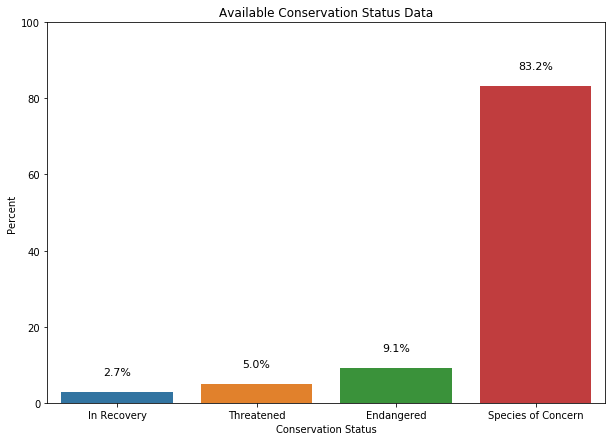

In [554]:
fig = plt.figure(figsize=(10,7))
g = sns.barplot(data=true, x='Conservation Status',y='Percent' )
ax=g
ax.set_title('Available Conservation Status Data')
for p in ax.patches:
    ax.annotate("%.1f%%" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                textcoords='offset points')
_ = g.set_ylim(0,100)

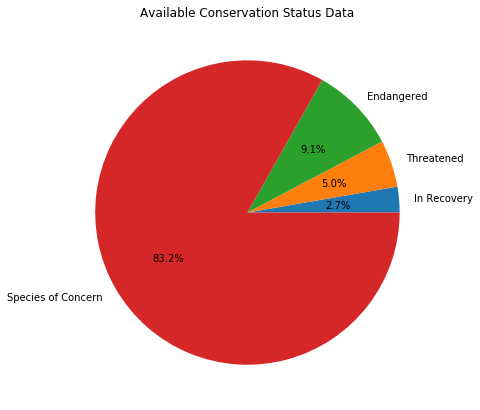

In [555]:
fig = plt.figure(figsize=(10,7))
plt.pie(true.Percent, labels=(true['Conservation Status'].unique()).tolist(), autopct='%0.1f%%')
plt.title('Available Conservation Status Data')
plt.show()

Majority of Aminals/Plants are a species of concern 

## Building Classifier Model

### Data Preprocessing

In [556]:
df1 = df.iloc[:,1:]
df1.drop('common_names', axis=1, inplace=True)

In [557]:
model = df1[df1.conservation_status.notnull()]

In [558]:
scale_mapper = {"In Recovery":0, "Threatened":1, "Endangered":2,'Species of Concern':3}
model["conservation_status"] = model["conservation_status"].replace(scale_mapper).astype('category')

In [559]:
model = pd.get_dummies(model, columns = ['park_name','category'])

In [560]:
cols = model.columns.tolist()
cols = cols[2:]+cols[:2]
model = model[cols]

In [561]:
target = model.iloc[:,-1:]
features = model.iloc[:,:-1]

### Training and Testing the Model

In [562]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [563]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier

In [564]:
rf = RandomForestClassifier(n_jobs=-1).fit(x_train,y_train)

In [565]:
param_grid = {'n_estimators': [10, 20, 30], 'max_depth': [6, 10, 20, 30]}
gridsearch = GridSearchCV(rf,
                          param_grid=param_grid, 
                          scoring='accuracy', cv=3, 
                          return_train_score=True, verbose=10)
gridsearch.fit(x_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] max_depth=6, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  max_depth=6, n_estimators=10, score=(train=0.936, test=0.914), total=   1.8s
[CV] max_depth=6, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  max_depth=6, n_estimators=10, score=(train=0.934, test=0.864), total=   0.1s
[CV] max_depth=6, n_estimators=10 ....................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV]  max_depth=6, n_estimators=10, score=(train=0.948, test=0.895), total=   0.1s
[CV] max_depth=6, n_estimators=20 ....................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s


[CV]  max_depth=6, n_estimators=20, score=(train=0.934, test=0.905), total=   0.2s
[CV] max_depth=6, n_estimators=20 ....................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.6s remaining:    0.0s


[CV]  max_depth=6, n_estimators=20, score=(train=0.941, test=0.886), total=   0.2s
[CV] max_depth=6, n_estimators=20 ....................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.9s remaining:    0.0s


[CV]  max_depth=6, n_estimators=20, score=(train=0.941, test=0.923), total=   0.2s
[CV] max_depth=6, n_estimators=30 ....................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.2s remaining:    0.0s


[CV]  max_depth=6, n_estimators=30, score=(train=0.936, test=0.905), total=   0.2s
[CV] max_depth=6, n_estimators=30 ....................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.5s remaining:    0.0s


[CV]  max_depth=6, n_estimators=30, score=(train=0.936, test=0.868), total=   0.2s
[CV] max_depth=6, n_estimators=30 ....................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    3.8s remaining:    0.0s


[CV]  max_depth=6, n_estimators=30, score=(train=0.948, test=0.905), total=   0.2s
[CV] max_depth=10, n_estimators=10 ...................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.1s remaining:    0.0s


[CV]  max_depth=10, n_estimators=10, score=(train=0.968, test=0.886), total=   0.2s
[CV] max_depth=10, n_estimators=10 ...................................
[CV]  max_depth=10, n_estimators=10, score=(train=0.970, test=0.882), total=   0.2s
[CV] max_depth=10, n_estimators=10 ...................................
[CV]  max_depth=10, n_estimators=10, score=(train=0.968, test=0.914), total=   0.1s
[CV] max_depth=10, n_estimators=20 ...................................
[CV]  max_depth=10, n_estimators=20, score=(train=0.970, test=0.900), total=   0.2s
[CV] max_depth=10, n_estimators=20 ...................................
[CV]  max_depth=10, n_estimators=20, score=(train=0.980, test=0.882), total=   0.2s
[CV] max_depth=10, n_estimators=20 ...................................
[CV]  max_depth=10, n_estimators=20, score=(train=0.973, test=0.905), total=   0.2s
[CV] max_depth=10, n_estimators=30 ...................................
[CV]  max_depth=10, n_estimators=30, score=(train=0.968, test=0.905), 

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   11.9s finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                              oob_score=False,
                                              random_

In [566]:
score = pd.DataFrame(gridsearch.cv_results_).sort_values(by='rank_test_score')
score.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
1,0.048268,0.001796,0.119791,0.007403,6,20,"{'max_depth': 6, 'n_estimators': 20}",0.904545,0.886364,0.922727,0.904545,0.014845,1,0.934091,0.940909,0.940909,0.938636,0.003214
8,0.076483,0.001501,0.115161,0.002228,20,30,"{'max_depth': 20, 'n_estimators': 30}",0.922727,0.881818,0.904545,0.903030,0.016735,2,0.972727,0.984091,0.979545,0.978788,0.004670
9,0.025259,0.002500,0.114962,0.004394,30,10,"{'max_depth': 30, 'n_estimators': 10}",0.918182,0.877273,0.909091,0.901515,0.017539,3,0.965909,0.975000,0.977273,0.972727,0.004910
10,0.048572,0.006656,0.120522,0.004016,30,20,"{'max_depth': 30, 'n_estimators': 20}",0.913636,0.886364,0.900000,0.900000,0.011134,4,0.968182,0.986364,0.979545,0.978030,0.007500
5,0.078043,0.000049,0.120241,0.007628,10,30,"{'max_depth': 10, 'n_estimators': 30}",0.904545,0.886364,0.900000,0.896970,0.007726,5,0.968182,0.977273,0.977273,0.974242,0.004285


In [567]:
rf_opt = RandomForestClassifier(max_depth = 10, 
                             n_estimators = 30, 
                             n_jobs = -1)
rf_opt.fit(x_train, y_train)
rf_opt.score(x_test, y_test)
print('Accuracy is %4.2f%%' %( 100 * rf_opt.score(x_test,y_test)))

Accuracy is 89.09%


In [568]:
predict  = rf_opt.predict(x_test)

In [569]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
print("Confusion Matrix:")
print(confusion_matrix(y_test, predict))
print()
print("Classification Report")
print(classification_report(y_test, predict))

Confusion Matrix:
[[  0   0   4   2]
 [  0   5   0   6]
 [  3   2  15   2]
 [  0   3   2 176]]

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.50      0.45      0.48        11
           2       0.71      0.68      0.70        22
           3       0.95      0.97      0.96       181

    accuracy                           0.89       220
   macro avg       0.54      0.53      0.53       220
weighted avg       0.87      0.89      0.88       220



The model is fairly accurate with an overall accuracy of 87%

In [570]:
inv_scale = {v: k for k, v in scale_mapper.items()}

In [571]:
y_test["conservation_status"] = y_test["conservation_status"].replace(inv_scale)
y_test['pred_status'] = predict
y_test['pred_status']= y_test.pred_status.replace(inv_scale)

In [572]:
y_test1 = y_test['conservation_status'].value_counts(normalize=True).reset_index()
y_test2 = y_test['pred_status'].value_counts(normalize=True).reset_index()
status = pd.merge(y_test1,y_test2,how='inner')

(0, 1)

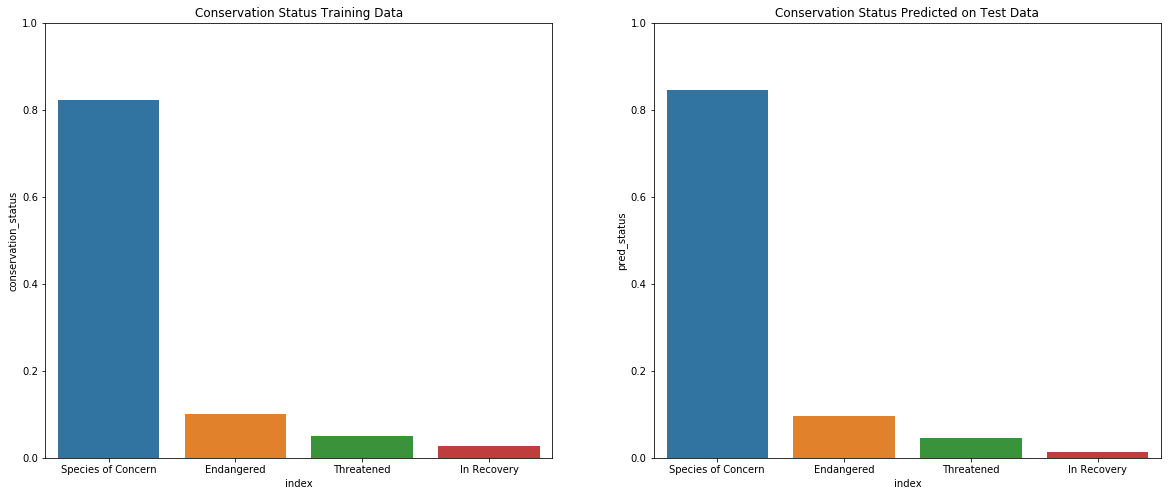

In [573]:
fig, axes = plt.subplots(1,2,figsize=(20,8))
sns.barplot(data=status, x='index', y='conservation_status', ax = axes[0]).set_title('Conservation Status Training Data')
sns.barplot(data=status, x='index', y='pred_status', ax=axes[1]).set_title('Conservation Status Predicted on Test Data')
axes[0].set_ylim(0,1)
axes[1].set_ylim(0,1)

The small difference in the two barplots above shows that the model is good at predicting conservation status

### Deployment of model on unseen data (NaN values in the original data)

In [574]:
un_d = df1[df1.conservation_status.isnull()]
un_d = pd.get_dummies(un_d, columns = ['park_name','category'])

In [575]:
cols = un_d.columns.tolist()
cols = cols[2:]+cols[:2]
un_d = un_d[cols]

In [576]:
un_d.drop('conservation_status', axis=1, inplace=True)

In [577]:
prediction  = rf_opt.predict(un_d)

In [578]:
un_d['status_prediction'] = prediction
un_d['status_prediction']= un_d.status_prediction.replace(inv_scale)

In [579]:
df01 = df1[df1.conservation_status.isnull()].reset_index()
df02 = df1[df1.conservation_status.notnull()].reset_index()
df01['conservation_status'] = un_d['status_prediction']

In [580]:
final = pd.merge(df01,df02,on='index',how='outer')

In [581]:
final['park_name']=final.park_name_x.fillna(final.park_name_y)
final['observations']=final.observations_x.fillna(final.observations_y)
final['category']=final.category_x.fillna(final.category_y)
final['conservation_status']=final.conservation_status_x.fillna(final.conservation_status_y)
final.drop(['park_name_x','park_name_y','observations_x','observations_y','category_x',\
            'category_y','conservation_status_x','conservation_status_y','index'],axis=1,inplace=True)

In [582]:
final1 = final.conservation_status.value_counts(normalize=True).reset_index()
final1.conservation_status = final1.conservation_status *100
final1.columns = ['Conservation Status','Percent']
final1 = final1.sort_values(by='Percent',ascending=True)

In [583]:
disp = pd.merge(true,final1, on='Conservation Status')
disp = disp.rename(columns = {'Percent_x':'Original without Prediction','Percent_y':'Original with Prediction'})
disp

,Conservation Status,Original without Prediction,Original with Prediction
0,In Recovery,2.727273,0.104940
1,Threatened,5.000000,1.226994
2,Endangered,9.090909,0.516629
3,Species of Concern,83.181818,98.151437


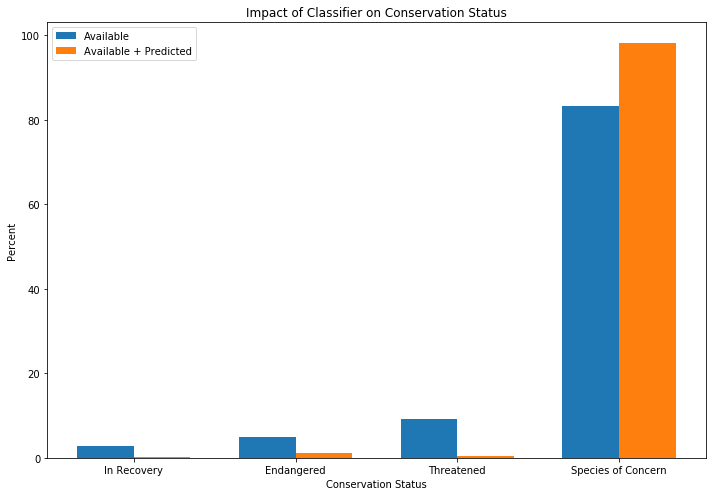

In [584]:
x = np.arange(len(final1['Conservation Status']))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, disp['Original without Prediction'], width, label='Available')
rects2 = ax.bar(x + width/2,disp['Original with Prediction'], width, label='Available + Predicted')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent')
ax.set_title('Impact of Classifier on Conservation Status')
ax.set_xlabel('Conservation Status')
ax.set_xticks(x)
ax.set_xticklabels(final1['Conservation Status'])
ax.legend()

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

The model predicted most of the animals/plants to be species of concern

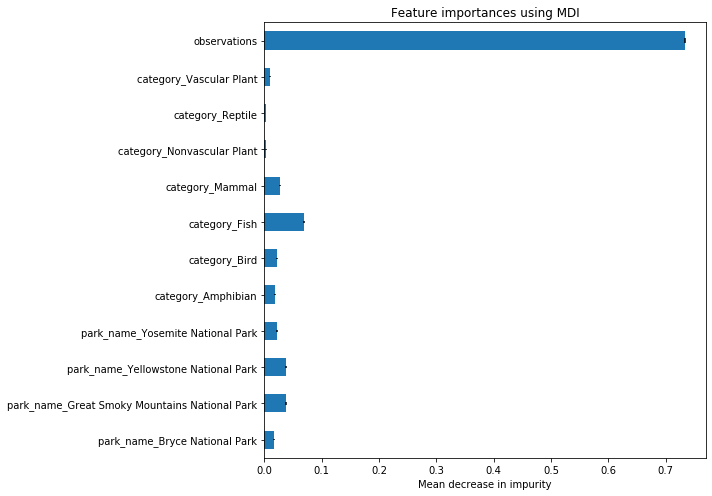

In [585]:
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances = pd.Series(importances, index=x_test.columns)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.barh(yerr=std, ax=ax,)
ax.set_title("Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
fig.tight_layout()

Observation is the main predictor of conservation status